In [1]:
import networkx as nx
import csv
import pandas as pd
import tqdm 
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_folder = "data/csv/"
file1 = "hashtag_usages_per_hour_9n_9ngranmarchaporlajusticia_weighted.txt"
file2 = "hashtag_usages_per_hour_noaltarifazo_ruidazonacional_weighted.txt"
graphs_folder = "graphs/"

In [9]:
df = pd.read_csv(data_folder + file1, sep=' ')
df_h = df["hour"].unique()
np.sort(df_h)


array([436983, 436984, 436985, 436986, 436987, 436988, 436989, 436990,
       436991, 436992, 436993, 436994, 436995, 436996, 436997, 436998,
       436999, 437000, 437001, 437002, 437003, 437004, 437005, 437006,
       437007, 437008, 437009, 437010, 437011, 437012, 437013, 437014,
       437015, 437016, 437017, 437018, 437019, 437020, 437021, 437022,
       437023, 437024, 437025, 437026, 437027, 437028, 437029, 437030,
       437031, 437032, 437033, 437034, 437035, 437036, 437037, 437038,
       437039, 437040, 437041, 437042, 437043, 437044, 437045, 437046,
       437047, 437048, 437049, 437050, 437051, 437052, 437053, 437054,
       437055, 437056, 437057, 437058, 437059, 437060, 437061, 437062,
       437063, 437064, 437065, 437066, 437067, 437068, 437069, 437070,
       437071, 437072, 437073, 437074, 437075, 437076, 437077, 437078,
       437079])

In [ ]:
G = nx.Graph()
for hour in df_h:
    print(hour)
    df_aux = df[(df["hour"] == hour)]
    df_users = df_aux["user"].unique()
    print("num users: ", df_users.shape[0])
    G.add_nodes_from(df_users)
    for user in tqdm.tqdm(df_users):
        df_user_hastag = df_aux.loc[df_aux["user"] == user]
        df_user_hastag = df_user_hastag["hashtag"]
        for hashtag in df_user_hastag:
            df_hashtag = df_aux.loc[df_aux["hashtag"] == hashtag]
            df_hashtag = df_hashtag["user"]
            for us in df_hashtag:
                if us != user:
                    if G.has_edge(user, us):
                        G[user][us]["weight"] += 1
                    elif G.has_edge(us, user):
                        print("B")                    
                        G[us][user]["weight"] += 1
                    else:
                        G.add_edge(user, us, weight = 1)
    nx.write_gexf(G, graphs_folder + "users_sharing_hashtags_" + str(hour) + ".gexf")

In [36]:
# Creo red de usuarios que comparten hastags
G = nx.Graph()
df_users = df["user"].unique()
print("num users: ", df_users.shape[0])
G.add_nodes_from(df_users)
for user in tqdm.tqdm(df_users):
    df_user_hastag = df.loc[df["user"] == user]
    df_user_hastag = df_user_hastag["hashtag"]
    #df_user_hastag.columns[1] = "hashtag"
    #print(df_user_hastag)
    #print("Encontrados ", df_user_hastag.shape[0], "hashtags del usuario ", user)
    for hashtag in df_user_hastag:
        df_hashtag = df.loc[df["hashtag"] == hashtag]
        df_hashtag = df_hashtag["user"]
        #print(df_hashtag.shape[0] , " usuarios comentaron sobre el hastag ", hashtag)
        for us in df_hashtag:
            # TODO Si buscamos eficiencia se puede quitar y añadir todas las conexiones y luego simplemente quitar la propia
            if us != user:
                # TODO Es no dirigido asi que el orden da igual(?)
                if G.has_edge(user, us):
                    #print("A")
                    G[user][us]["weight"] += 1
                elif G.has_edge(us, user):
                    print("B")                    
                    G[us][user]["weight"] += 1
                else:
                    G.add_edge(user, us, weight = 1)
nx.write_gexf(G, graphs_folder + "users_sharing_hashtags.gexf")

num users:  8022


  0%|          | 0/8022 [00:00<?, ?it/s]

 45%|████▌     | 3639/8022 [14:25<18:18,  3.99it/s]   

In [ ]:
# Creo red de hastags que comparten usuarios
G = nx.Graph()
for hour in df_h:
    print(hour)
    df_aux = df[(df["hour"] == hour)]
    df_hashtags = df_aux["hashtag"].unique()
    print("num hashtags: ", df_hashtags.shape[0])
    G.add_nodes_from(df_hashtags)
    for hashtag in tqdm.tqdm(df_hashtags):
        df_hashtag_user = df_aux.loc[df_aux["hashtag"] == hashtag]
        df_hashtag_user = df_hashtag_user["user"]
        for user in df_hashtag_user:
            df_user = df_aux.loc[df_aux["user"] == user]
            df_user = df_user["hashtag"]
            #print(df_hashtag.shape[0] , " usuarios comentaron sobre el hastag ", hashtag)
            for hash in df_user:
                # TODO Si buscamos eficiencia se puede quitar y añadir todas las conexiones y luego simplemente quitar la propia
                if hash != hashtag:
                    # TODO Es no dirigido asi que el orden da igual(?)
                    if G.has_edge(hashtag, hash):
                        #print("A")
                        G[hashtag][hash]["weight"] += 1
                    elif G.has_edge(hash, hashtag):
                        print("B")                    
                        G[hash][hashtag]["weight"] += 1
                    else:
                        G.add_edge(hashtag, hash, weight = 1)
    nx.write_gexf(G, graphs_folder + "hashtags_sharing_users_" + str(hour) + ".gexf")

In [4]:
def add_nodes_subgraph(G, treshold):
    F = nx.Graph()
    for node in G.nodes():
        # Comprobamos si el grado del nodo es mayor que el umbral
        if G.degree[node] > treshold:
            # Añadimos el nodo
            F.add_node(node)
    return F

In [5]:
def add_edges_subgraph(G, F):
    for node in F.nodes():
        # Se itera sobre los vecinos en G de cada nodo y vemos si estan en F
        for neighbor in G.neighbors(node):
            if neighbor in F.nodes():
                # Se añade la arista si no existe ya
                if not neighbor in F.neighbors(node):
                    F.add_edge(node, neighbor)
    return F

In [3]:
def tresh_normalization(G, treshold):
    F = add_nodes_subgraph(G, treshold)
    
    # Ahora añadimos las aristas de G de los nodos en el subgrafo F
    F = add_edges_subgraph(G, F)

    return F


In [6]:
def calc_clust(G):
    dict_tres = {}
    for i in tqdm.tqdm(range(600)):
        treshold = i
        F = tresh_normalization(G,treshold)
        #TODO mirar cugraph https://github.com/rapidsai/cugraph/tree/branch-24.06/python/nx-cugraph
        clust  = nx.clustering(F)
        avg_clust = np.mean(np.array(list(clust.values())))
        #print("Cargado el subgrafo con umbral " + str(treshold) + ', numero de nodos: ' + str(F.number_of_nodes()) + ', numero de aristas: ' + str(F.number_of_edges()) + ', clusterizacion media: ' + str(avg_clust))
        dict_tres[treshold] = avg_clust
    return dict_tres

In [7]:
def plot_clust(dict_tres, name_graph):
    # Obtener las claves y los valores del diccionario
    claves = list(dict_tres.keys())
    valores = list(dict_tres.values())

    plt.figure(figsize=(14,7)) 
    plt.xlabel('KT')
    plt.ylabel('average c(KT)')

    plt.scatter(claves, valores, s=1, marker="x")

    plt.savefig("plots/" + name_graph.split('_')[-1])
    plt.show()

In [8]:
def load_graph(name_graph):
    full_graph_path = "graphs/" + name_graph + ".gexf"
    # Cargamos el grafo
    G = nx.read_gexf(full_graph_path)
    print("Cargado el grafo de la hora " + name_graph.split('_')[-1] + ', numero de nodos: ' + str(G.number_of_nodes()) + ', numero de aristas: ' + str(G.number_of_edges()))
    return G

In [9]:
def calc_plot(name_graph):
    G = load_graph(name_graph)
    dict_tres = calc_clust(G)
    plot_clust(dict_tres, name_graph)

Cargado el grafo de la hora 436993, numero de nodos: 16045, numero de aristas: 246383


100%|██████████| 600/600 [34:06<00:00,  3.41s/it] 


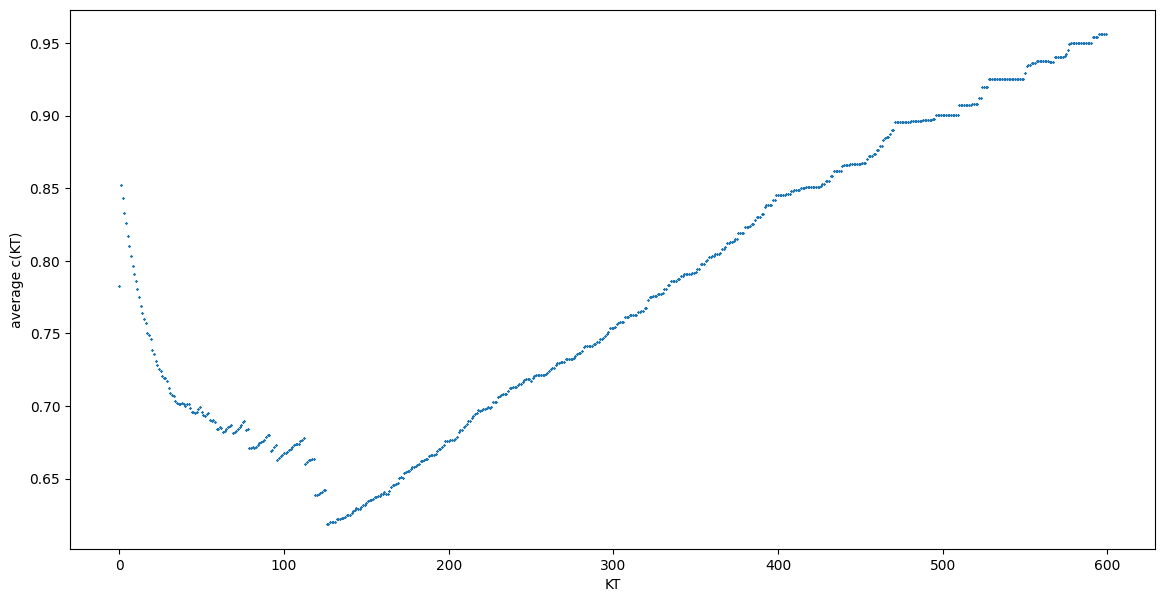

Cargado el grafo de la hora 437028, numero de nodos: 15232, numero de aristas: 228199


100%|██████████| 600/600 [27:00<00:00,  2.70s/it] 


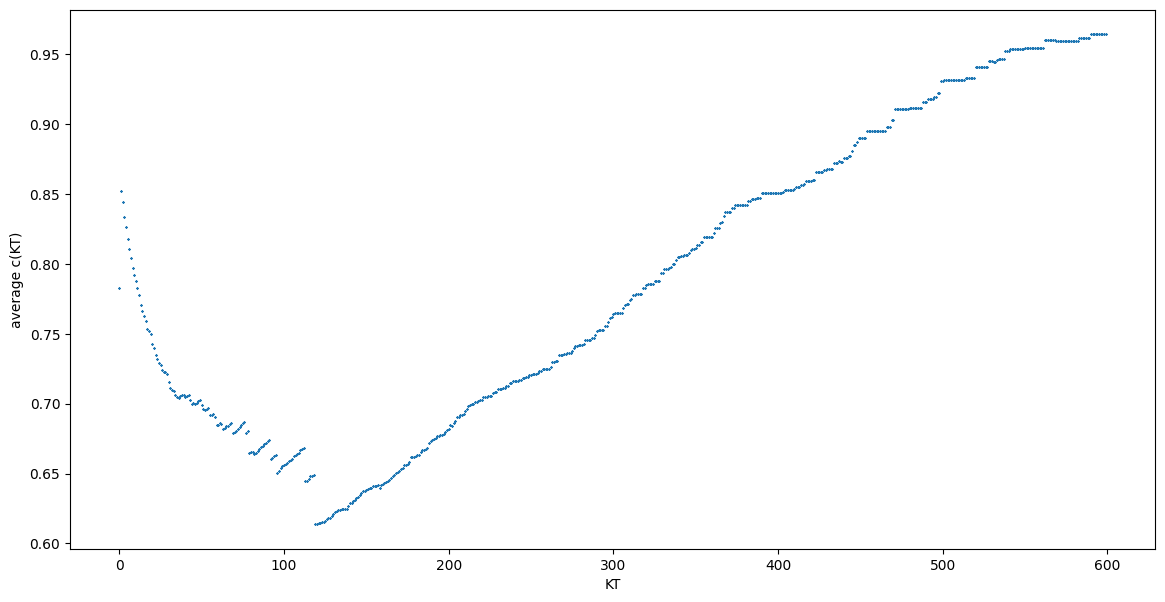

Cargado el grafo de la hora 436986, numero de nodos: 8410, numero de aristas: 108236


100%|██████████| 600/600 [06:32<00:00,  1.53it/s] 


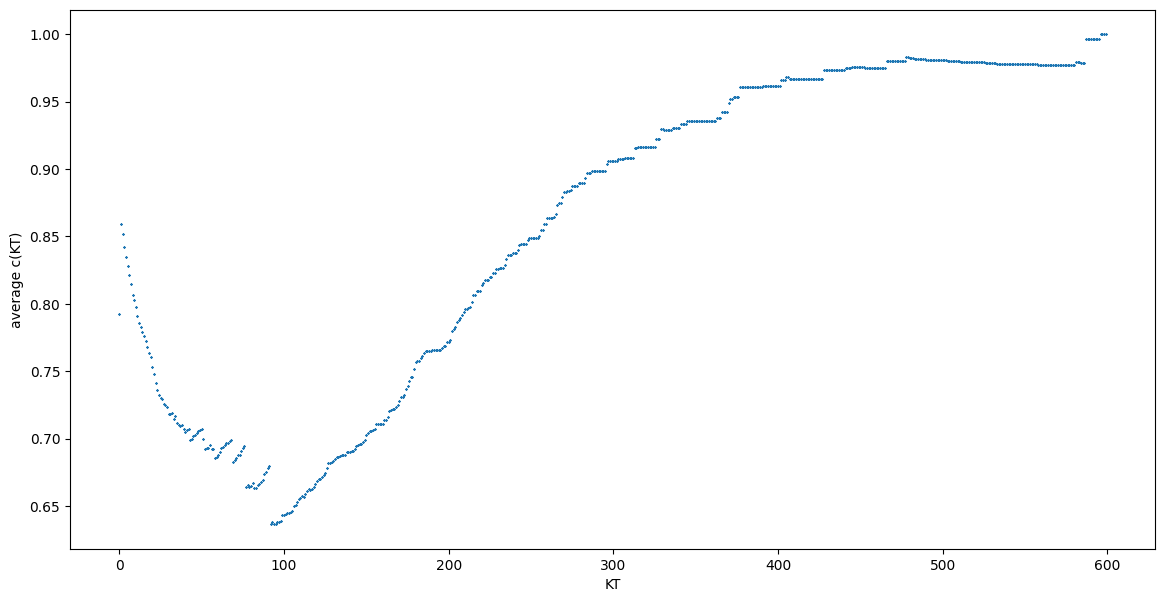

Cargado el grafo de la hora 437029, numero de nodos: 12181, numero de aristas: 177716


100%|██████████| 600/600 [12:13<00:00,  1.22s/it] 


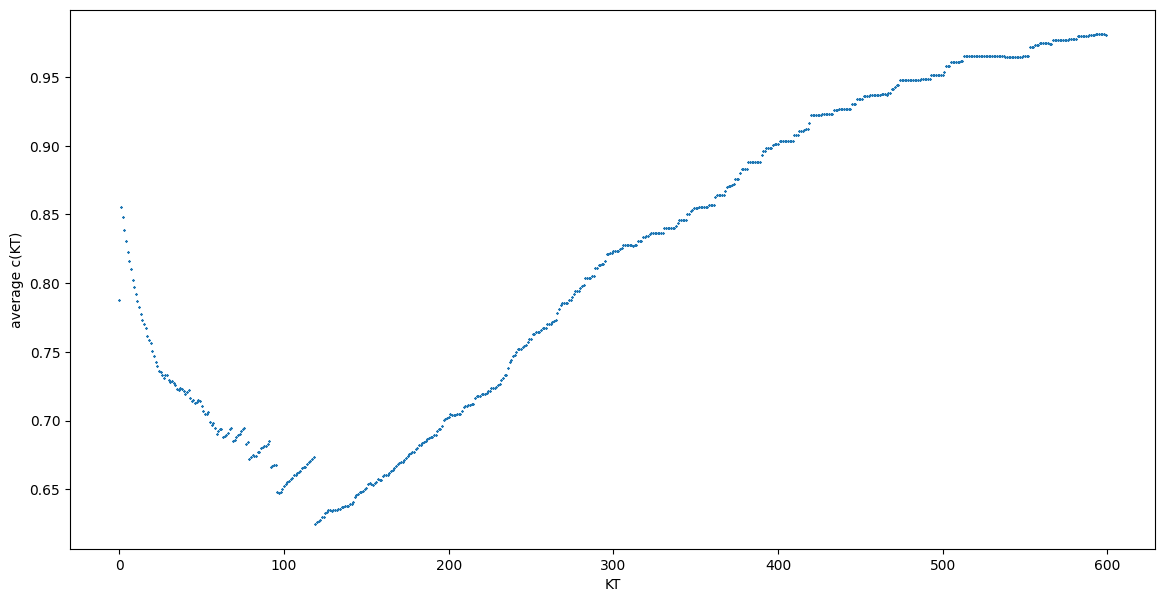

Cargado el grafo de la hora 437076, numero de nodos: 16828, numero de aristas: 260486


100%|██████████| 600/600 [26:10<00:00,  2.62s/it] 


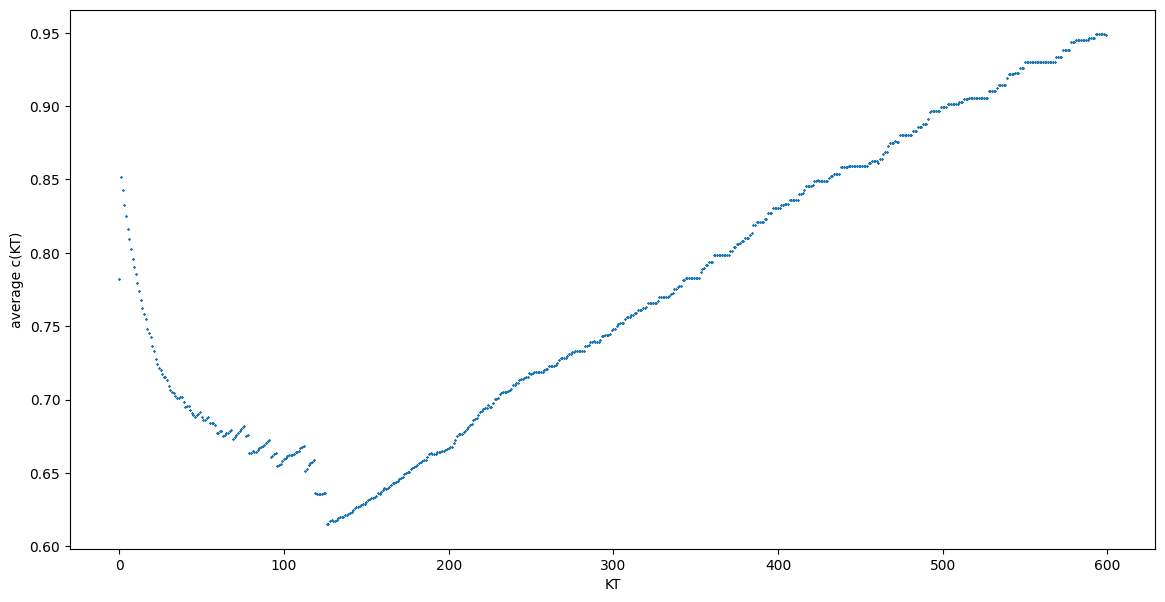

Cargado el grafo de la hora 437025, numero de nodos: 7383, numero de aristas: 94765


100%|██████████| 600/600 [03:54<00:00,  2.55it/s]


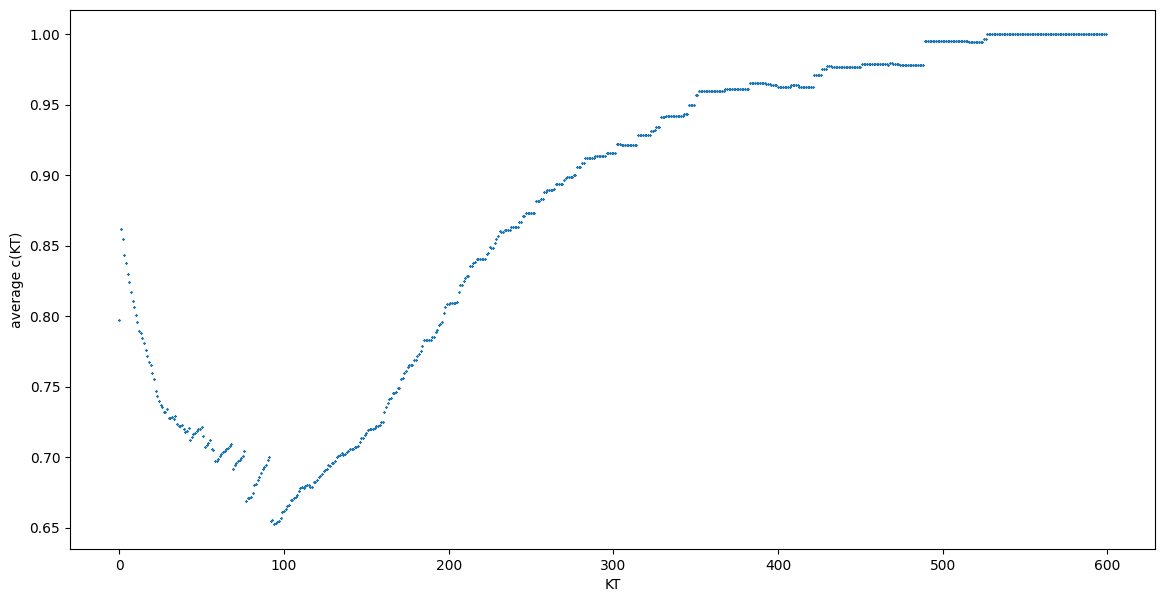

Cargado el grafo de la hora 437000, numero de nodos: 17364, numero de aristas: 268794


100%|██████████| 600/600 [27:57<00:00,  2.80s/it] 


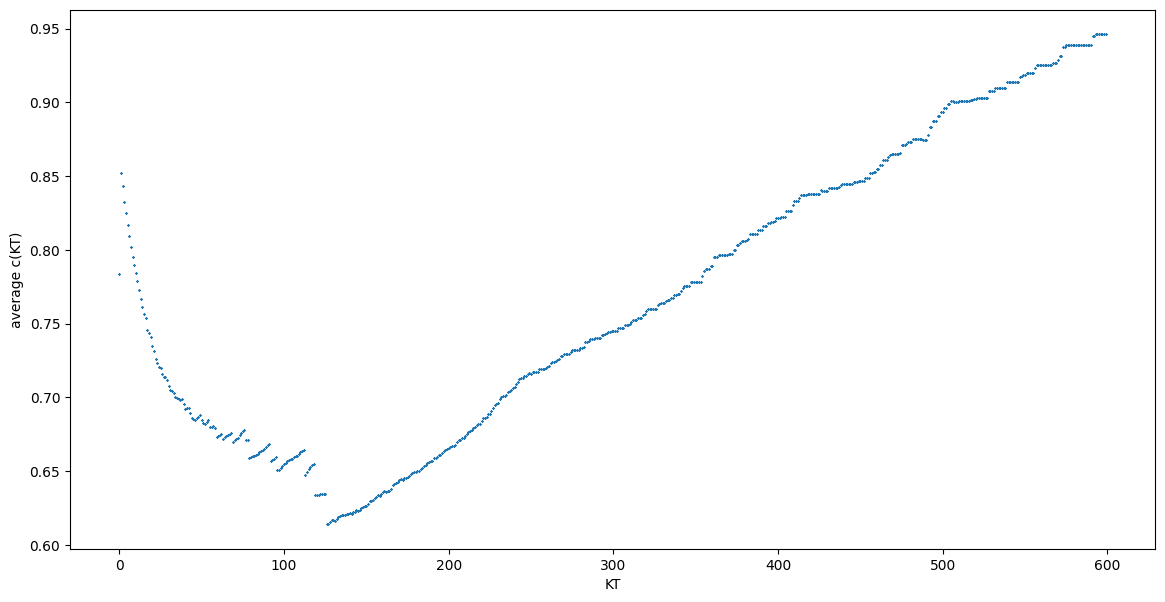

Cargado el grafo de la hora 437061, numero de nodos: 5172, numero de aristas: 66143


100%|██████████| 600/600 [02:02<00:00,  4.89it/s] 


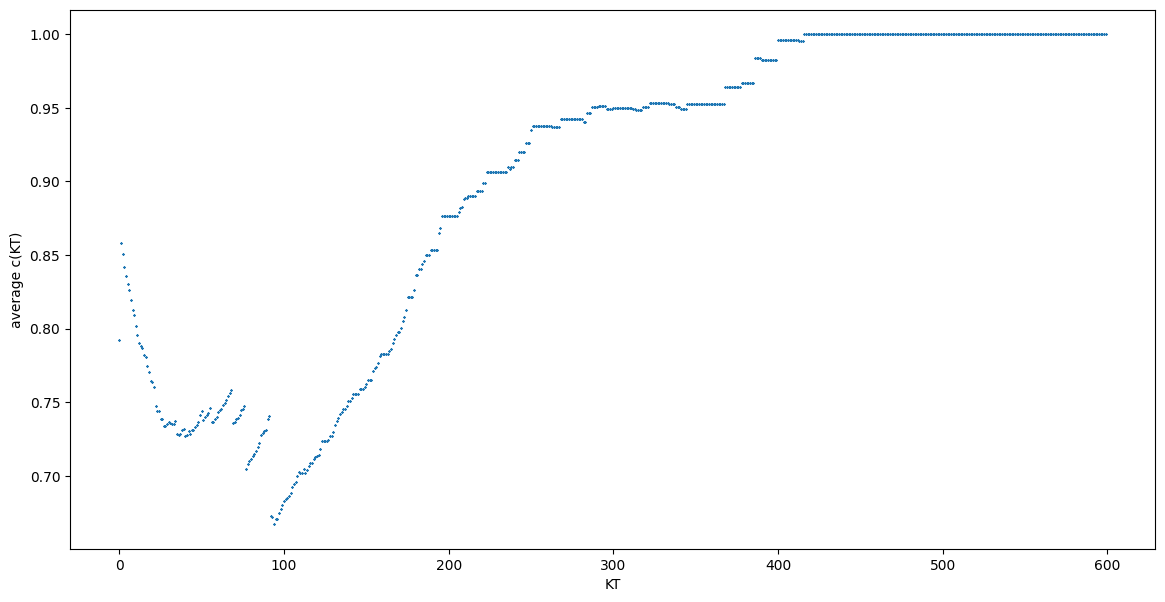

Cargado el grafo de la hora 437042, numero de nodos: 10747, numero de aristas: 149636


100%|██████████| 600/600 [08:57<00:00,  1.12it/s] 


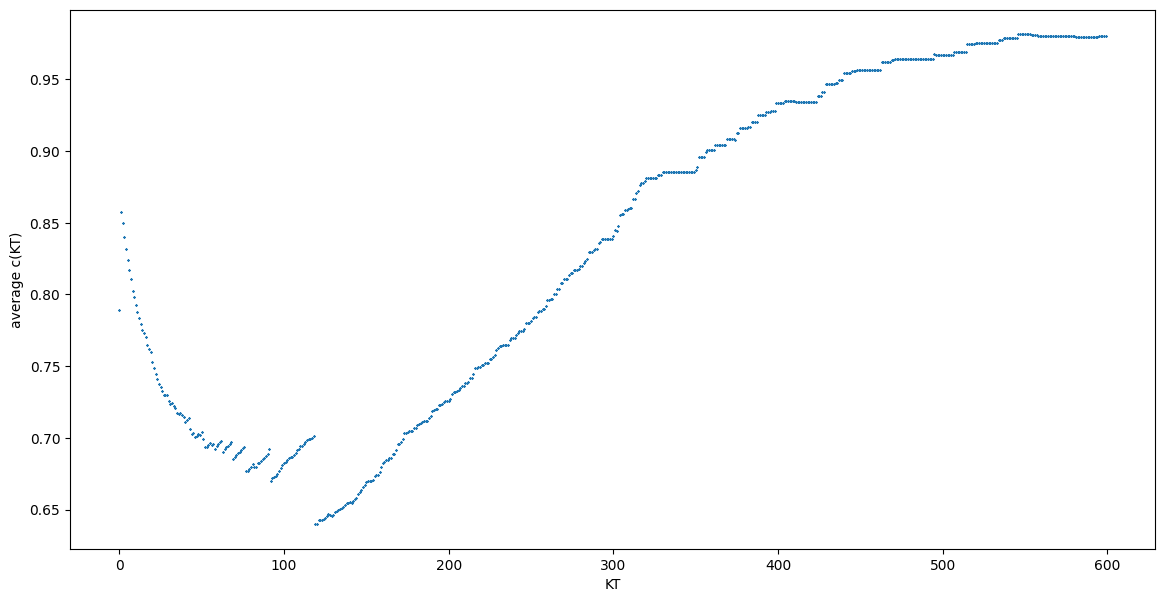

Cargado el grafo de la hora 437013, numero de nodos: 18019, numero de aristas: 279412


100%|██████████| 600/600 [29:55<00:00,  2.99s/it] 


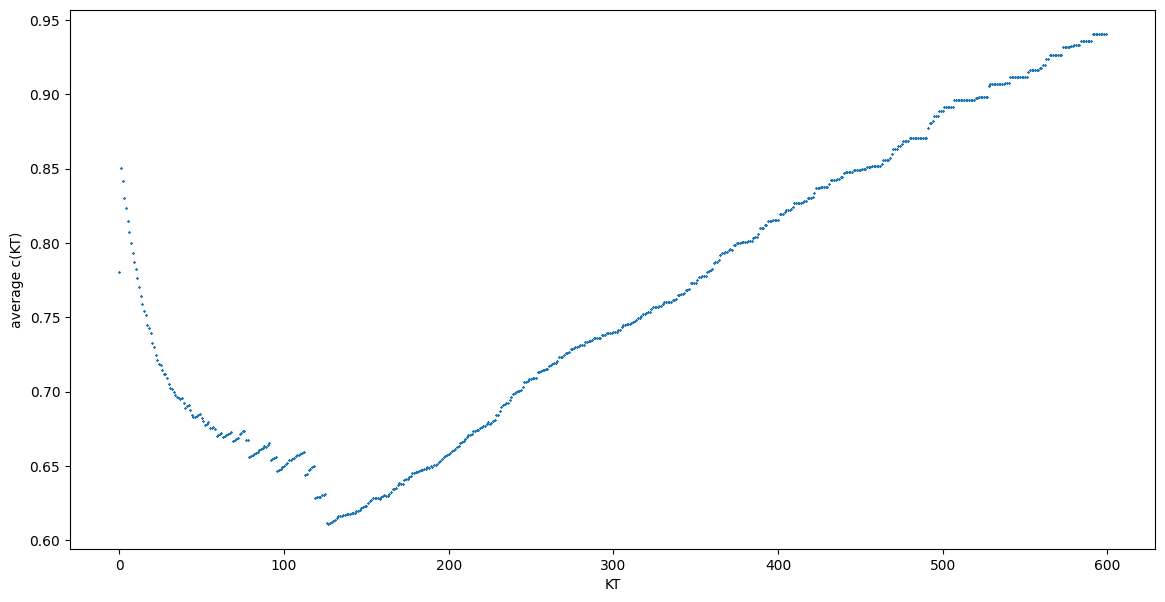

Cargado el grafo de la hora 436990, numero de nodos: 15041, numero de aristas: 224580


100%|██████████| 600/600 [19:03<00:00,  1.91s/it] 


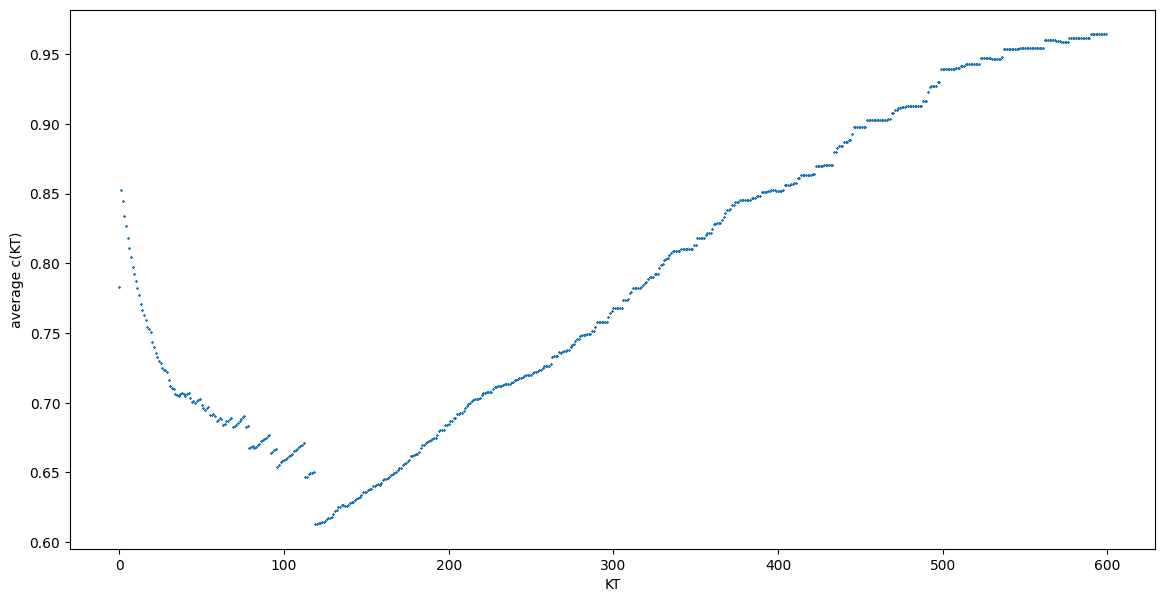

Cargado el grafo de la hora 437069, numero de nodos: 14062, numero de aristas: 207263


100%|██████████| 600/600 [16:40<00:00,  1.67s/it] 


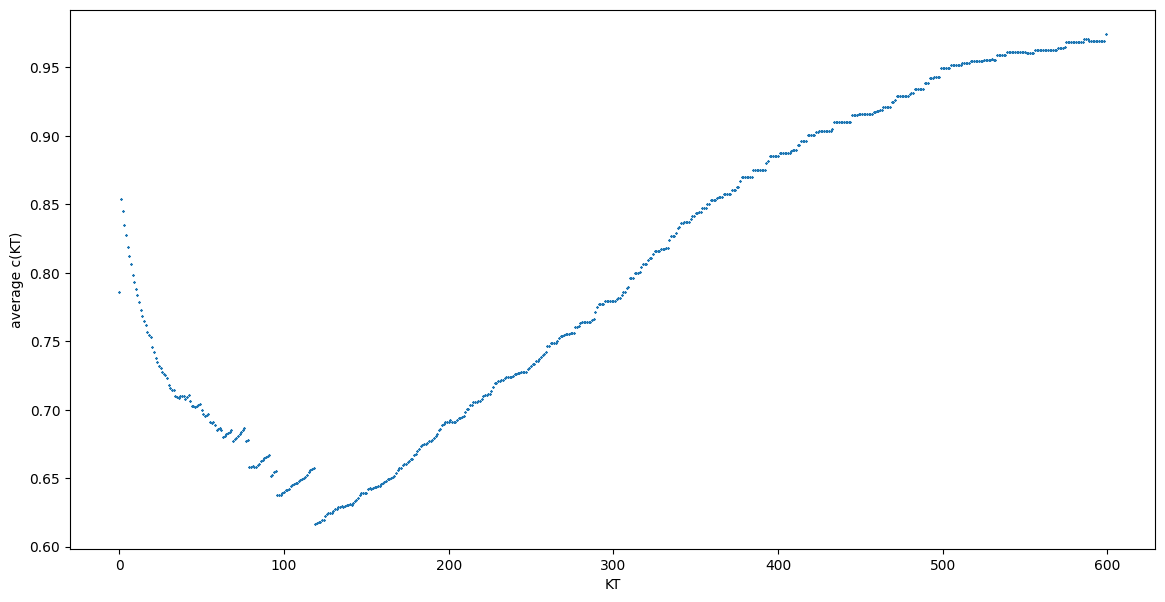

Cargado el grafo de la hora 437075, numero de nodos: 15507, numero de aristas: 238890


100%|██████████| 600/600 [22:01<00:00,  2.20s/it] 


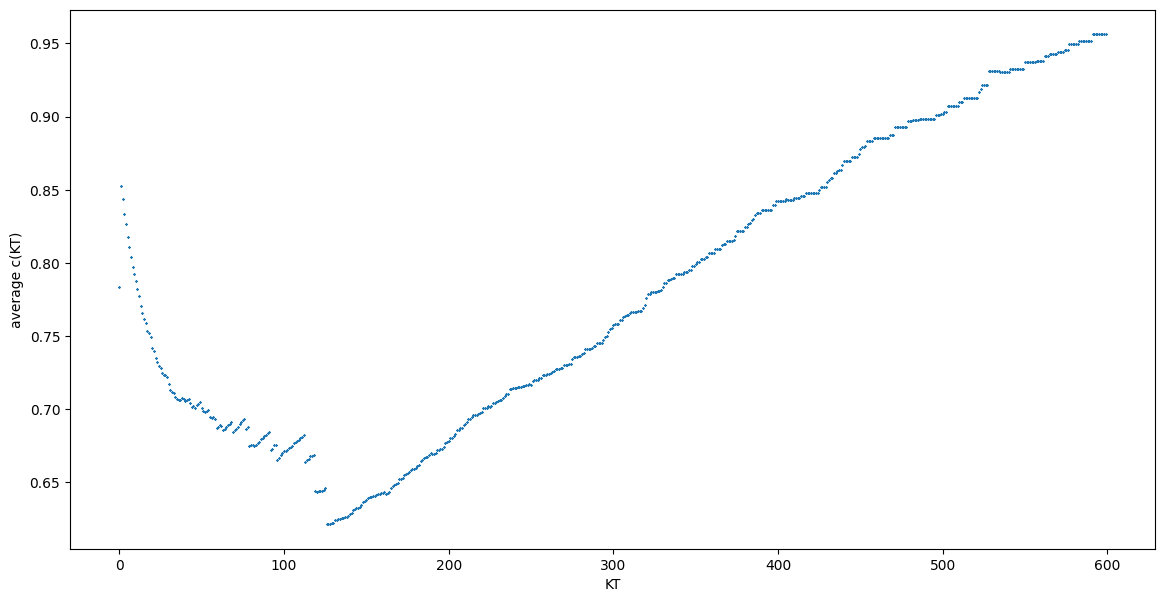

Cargado el grafo de la hora 436998, numero de nodos: 10037, numero de aristas: 138149


100%|██████████| 600/600 [07:41<00:00,  1.30it/s] 


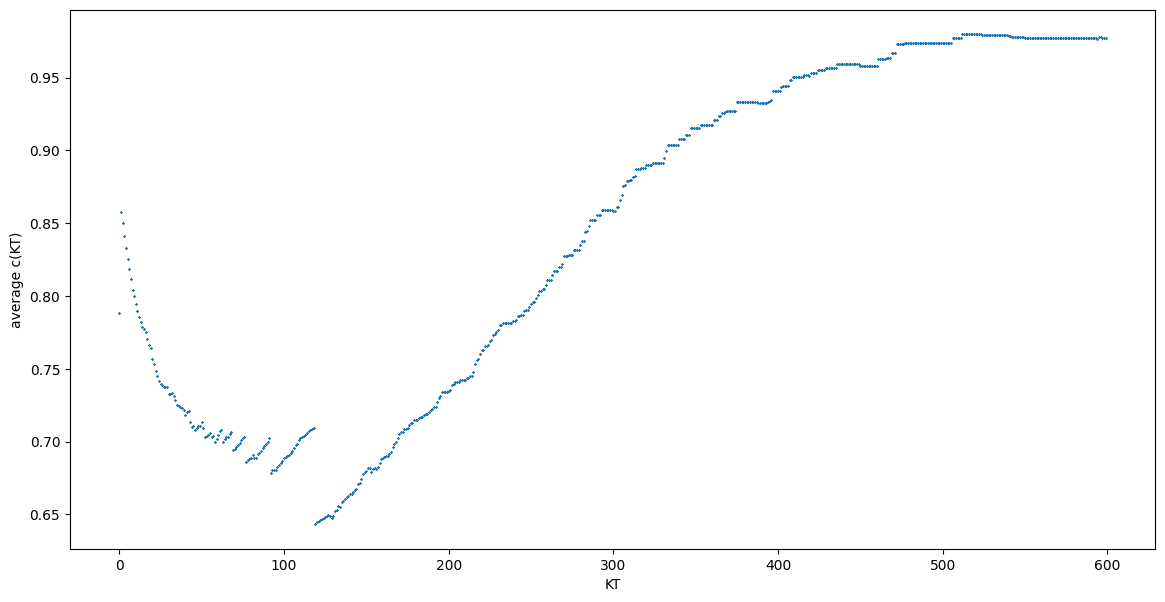

Cargado el grafo de la hora 437052, numero de nodos: 11548, numero de aristas: 167019


100%|██████████| 600/600 [11:14<00:00,  1.12s/it] 


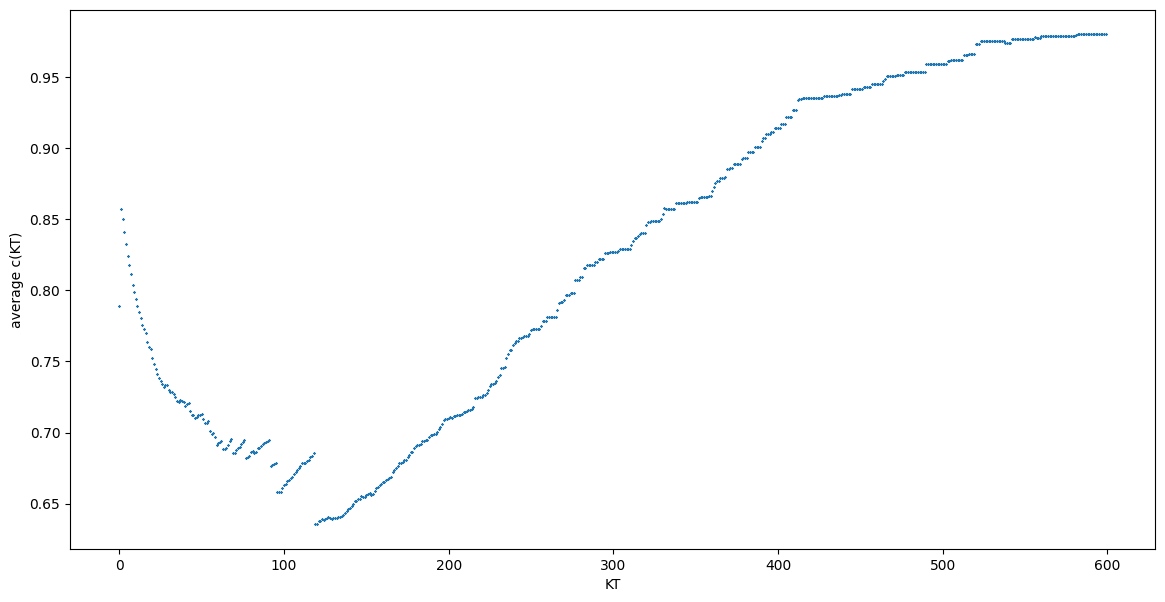

Cargado el grafo de la hora 437007, numero de nodos: 4115, numero de aristas: 52748


100%|██████████| 600/600 [01:20<00:00,  7.43it/s] 


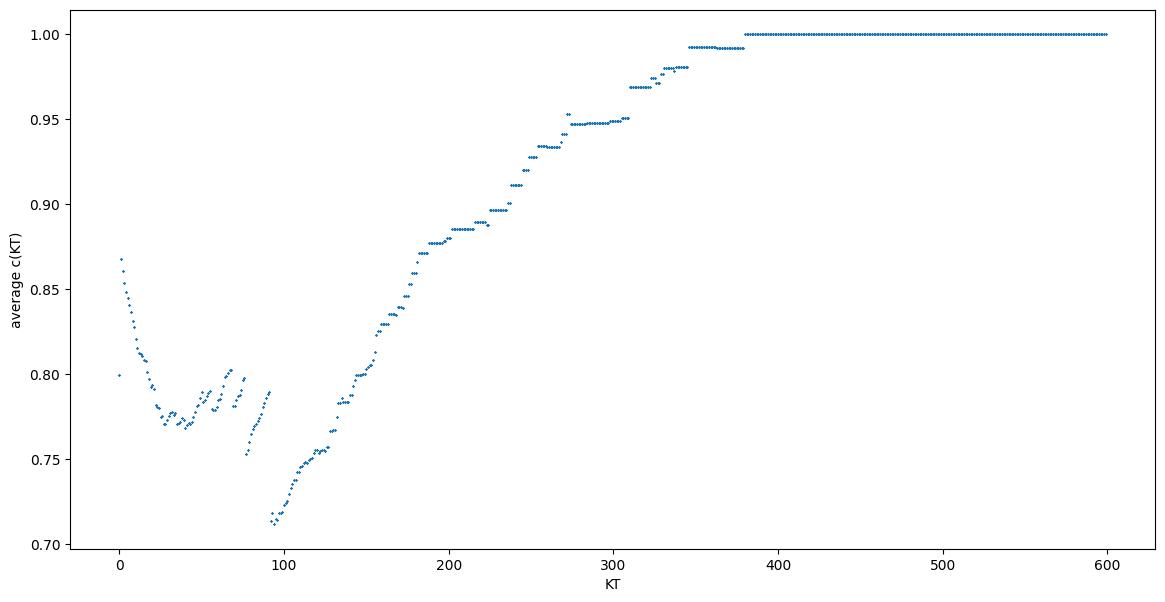

Cargado el grafo de la hora 437078, numero de nodos: 5481, numero de aristas: 68570


100%|██████████| 600/600 [02:11<00:00,  4.55it/s] 


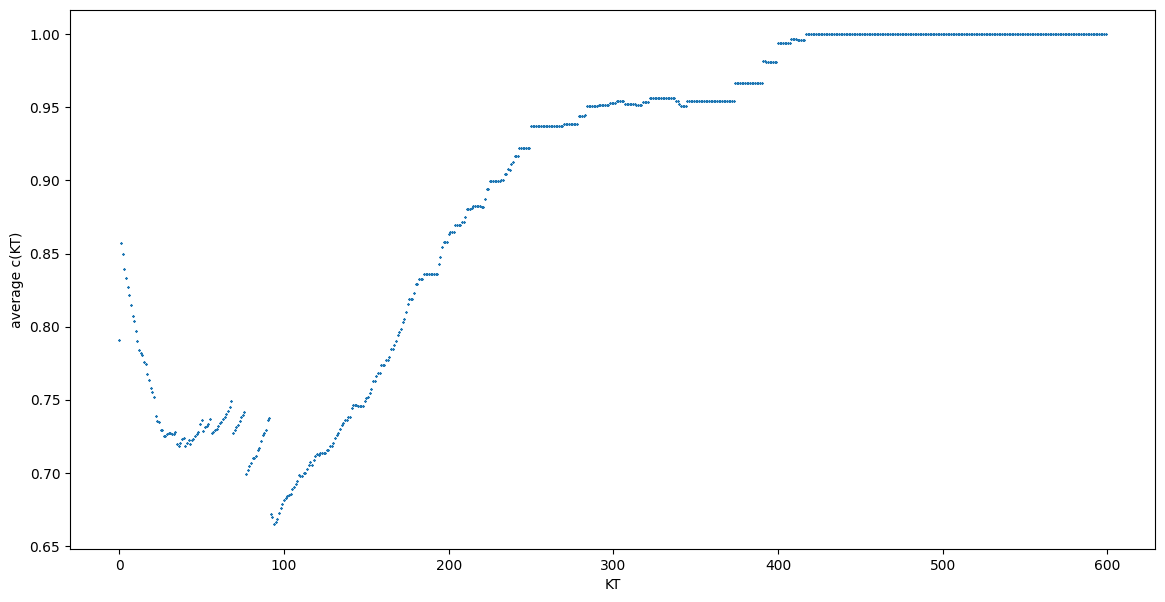

Cargado el grafo de la hora 437060, numero de nodos: 8162, numero de aristas: 106549


100%|██████████| 600/600 [04:57<00:00,  2.01it/s]


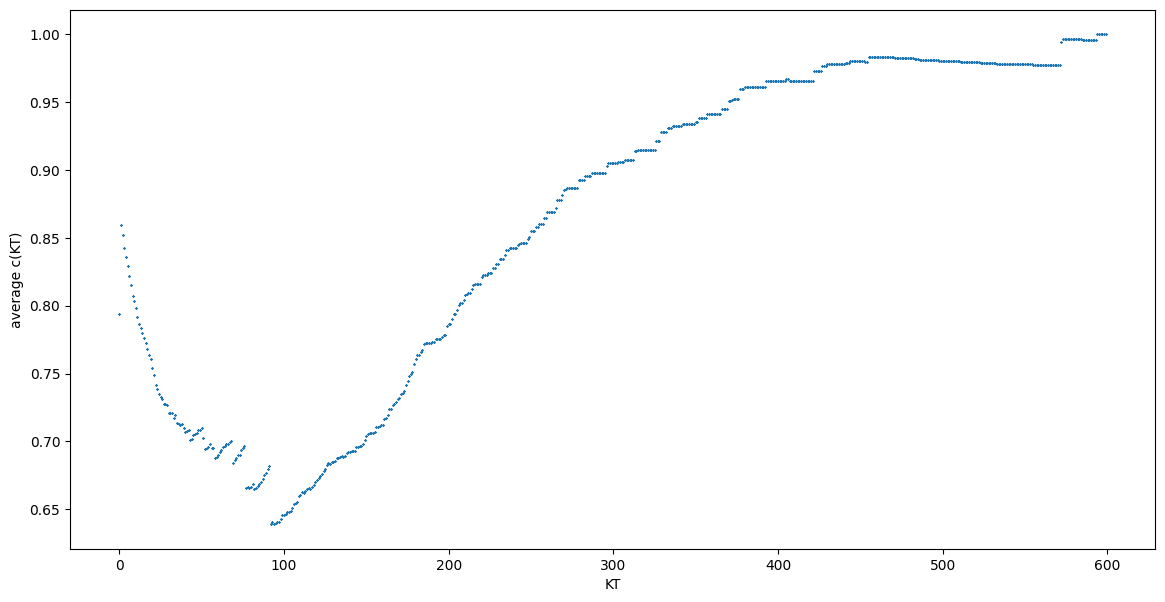

Cargado el grafo de la hora 436987, numero de nodos: 8945, numero de aristas: 120980


100%|██████████| 600/600 [06:01<00:00,  1.66it/s]


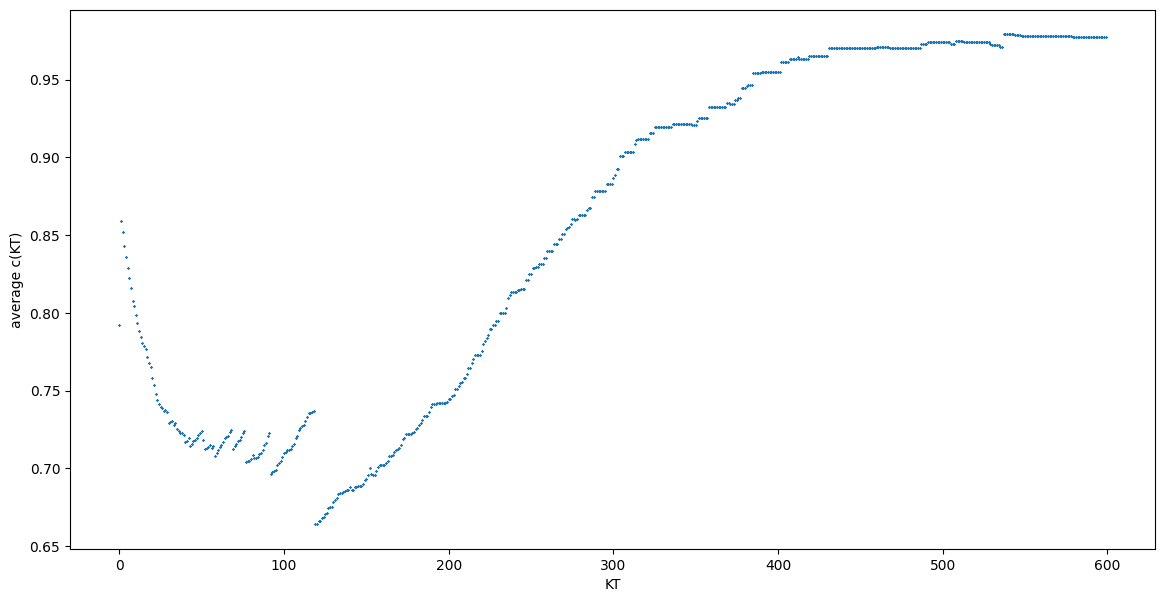

Cargado el grafo de la hora 437006, numero de nodos: 2695, numero de aristas: 32346


100%|██████████| 600/600 [00:33<00:00, 17.96it/s] 


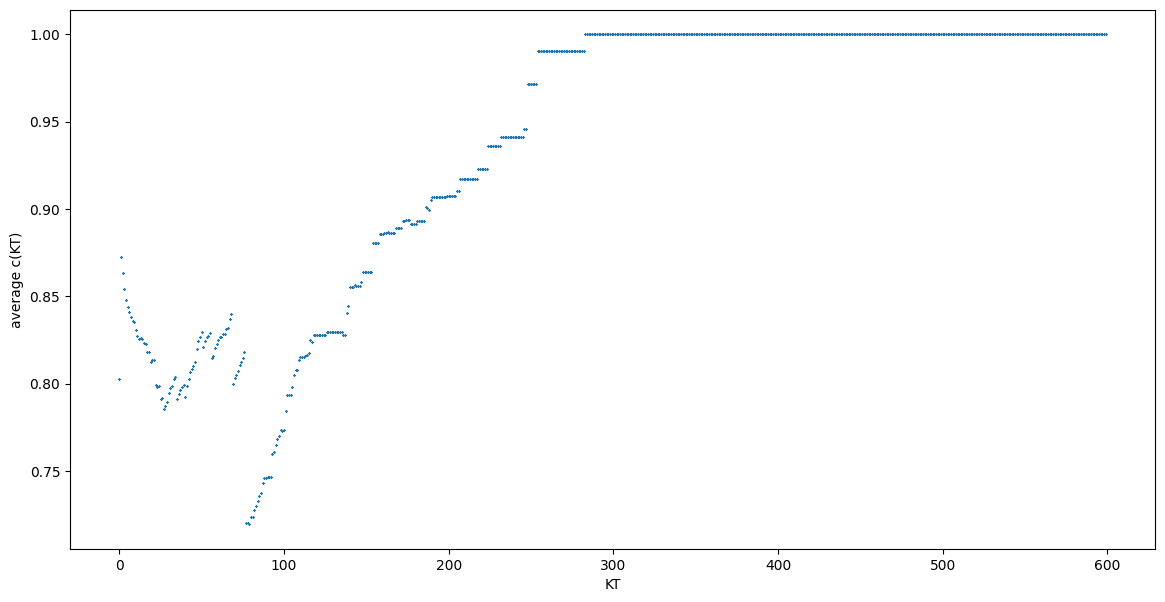

Cargado el grafo de la hora 436995, numero de nodos: 3349, numero de aristas: 41637


100%|██████████| 600/600 [00:53<00:00, 11.17it/s] 


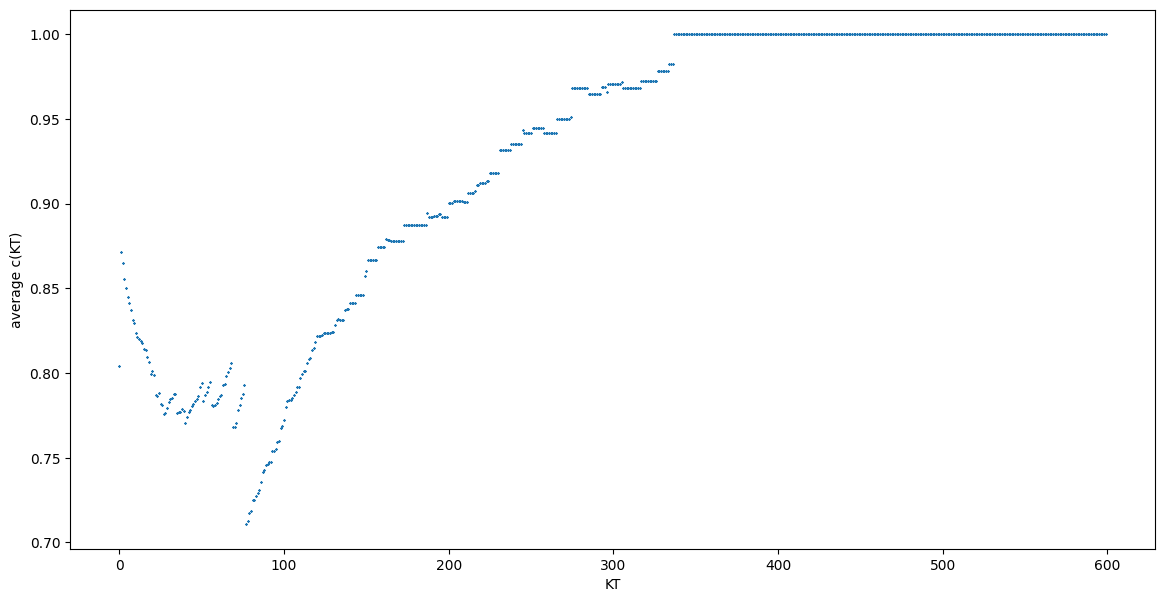

Cargado el grafo de la hora 437072, numero de nodos: 17706, numero de aristas: 275005


100%|██████████| 600/600 [29:19<00:00,  2.93s/it] 


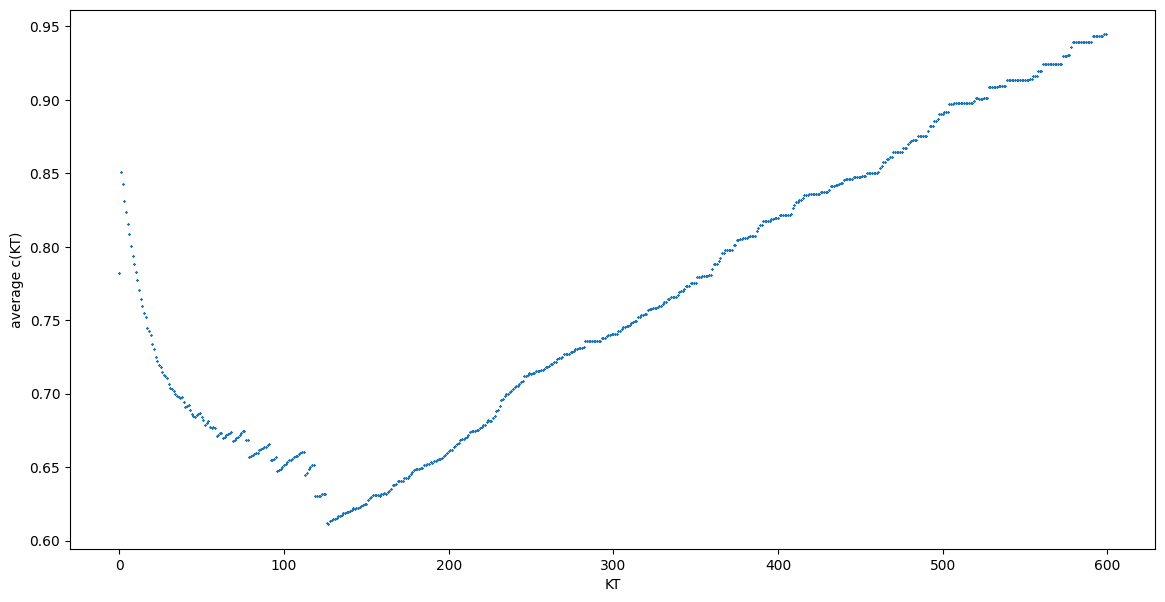

Cargado el grafo de la hora 437047, numero de nodos: 8462, numero de aristas: 109116


100%|██████████| 600/600 [05:05<00:00,  1.97it/s]


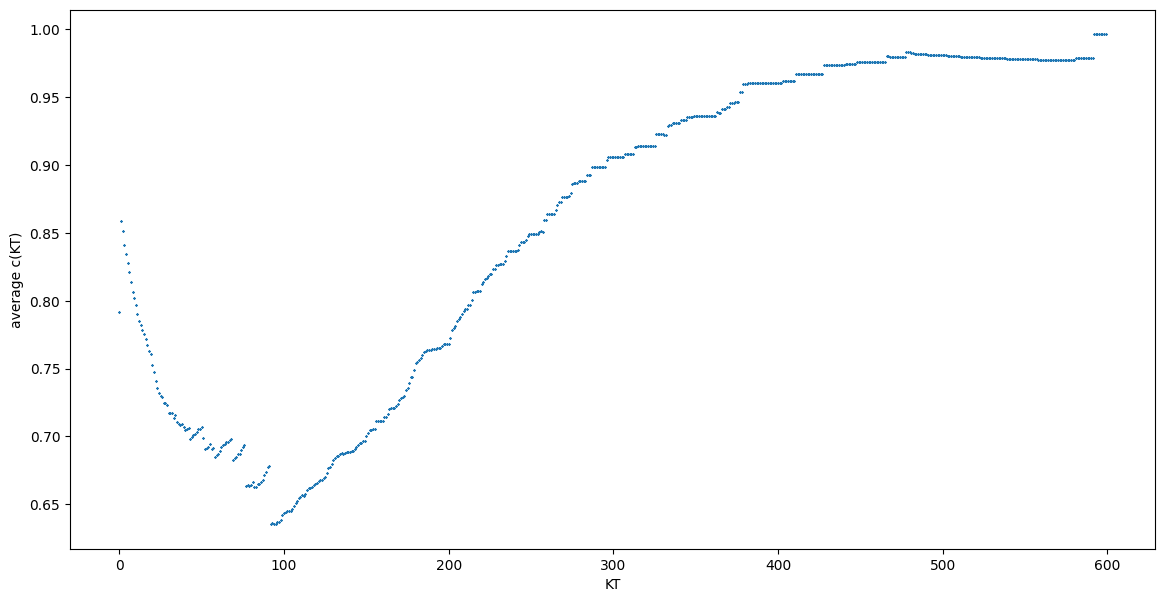

Cargado el grafo de la hora 437071, numero de nodos: 17665, numero de aristas: 274157


100%|██████████| 600/600 [28:54<00:00,  2.89s/it] 


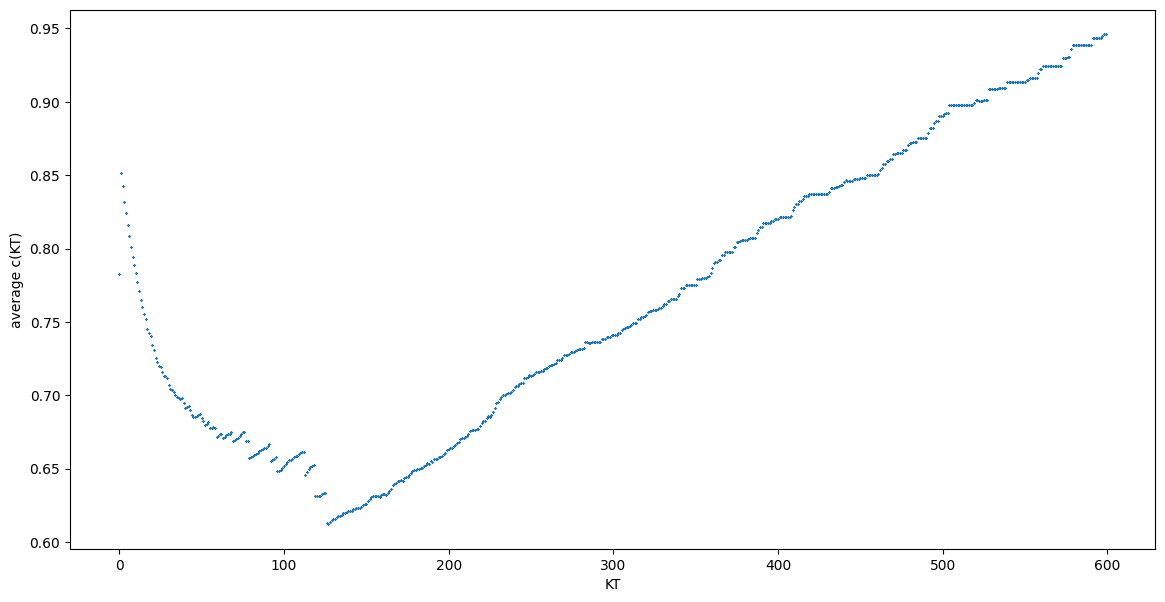

Cargado el grafo de la hora 436984, numero de nodos: 13396, numero de aristas: 195339


100%|██████████| 600/600 [14:49<00:00,  1.48s/it] 


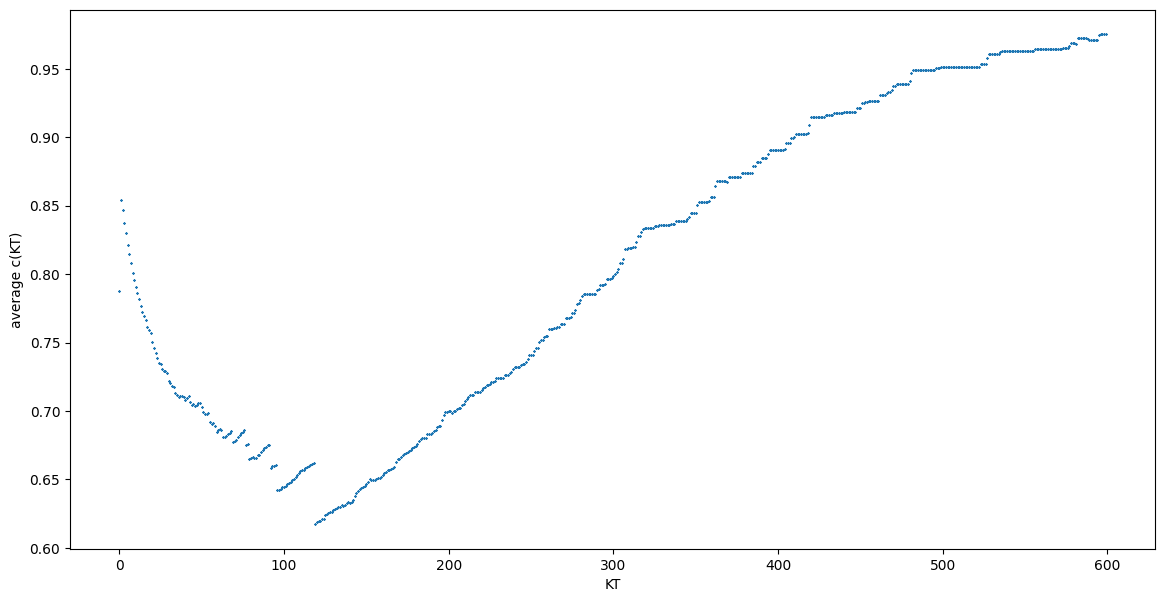

Cargado el grafo de la hora 437017, numero de nodos: 12435, numero de aristas: 182218


100%|██████████| 600/600 [12:58<00:00,  1.30s/it] 


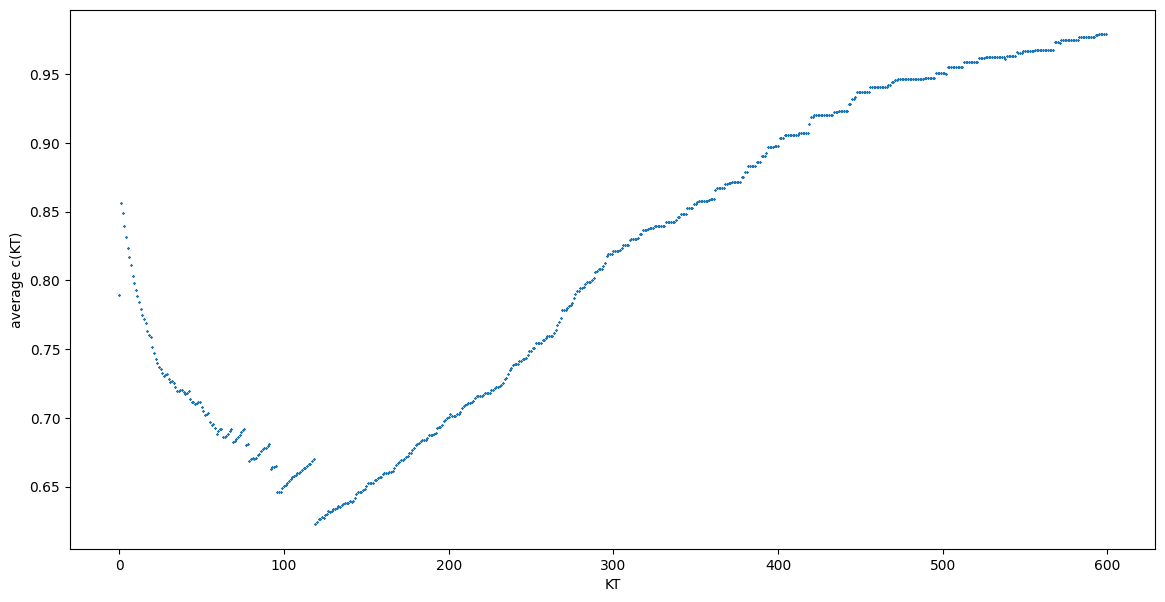

Cargado el grafo de la hora 436996, numero de nodos: 14170, numero de aristas: 208277


100%|██████████| 600/600 [16:39<00:00,  1.67s/it] 


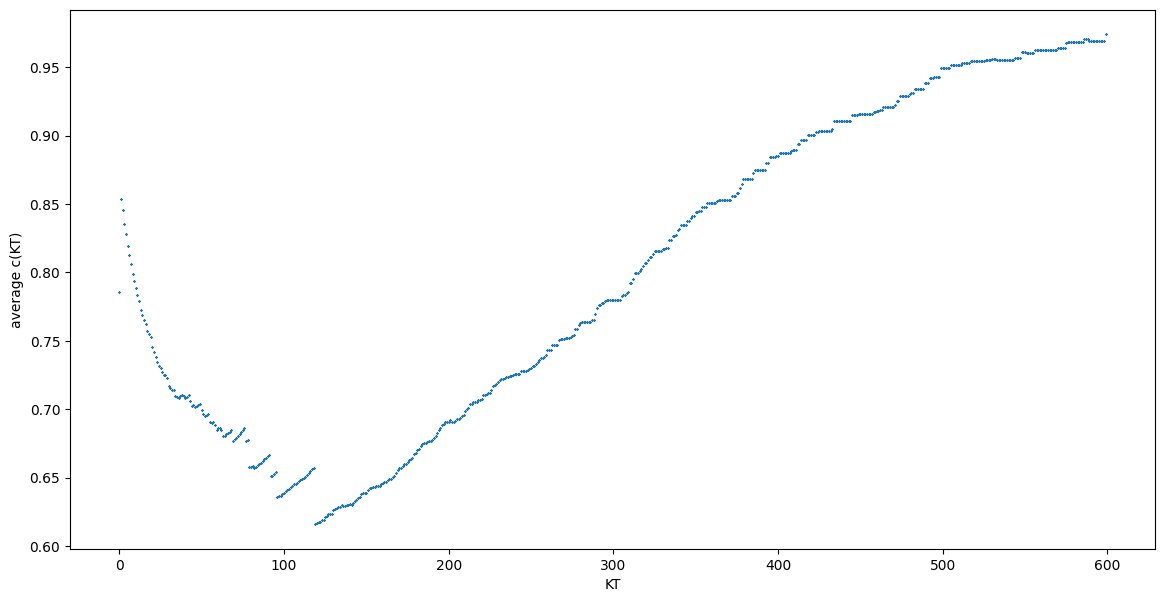

Cargado el grafo de la hora 437079, numero de nodos: 14875, numero de aristas: 222615


100%|██████████| 600/600 [18:53<00:00,  1.89s/it] 


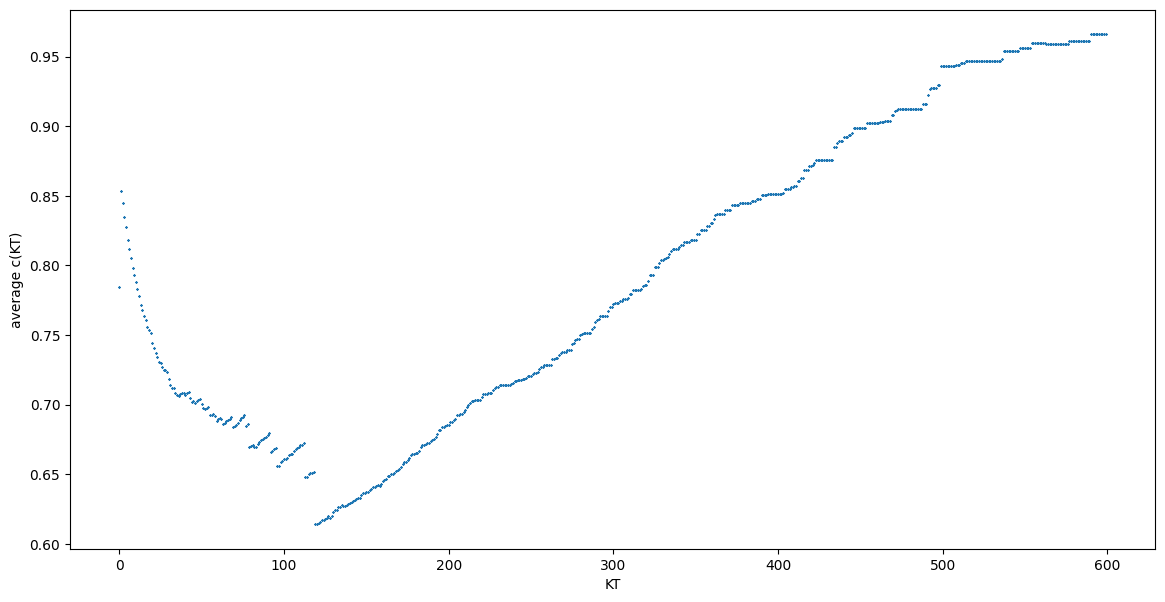

Cargado el grafo de la hora 437063, numero de nodos: 13829, numero de aristas: 200744


100%|██████████| 600/600 [15:36<00:00,  1.56s/it] 


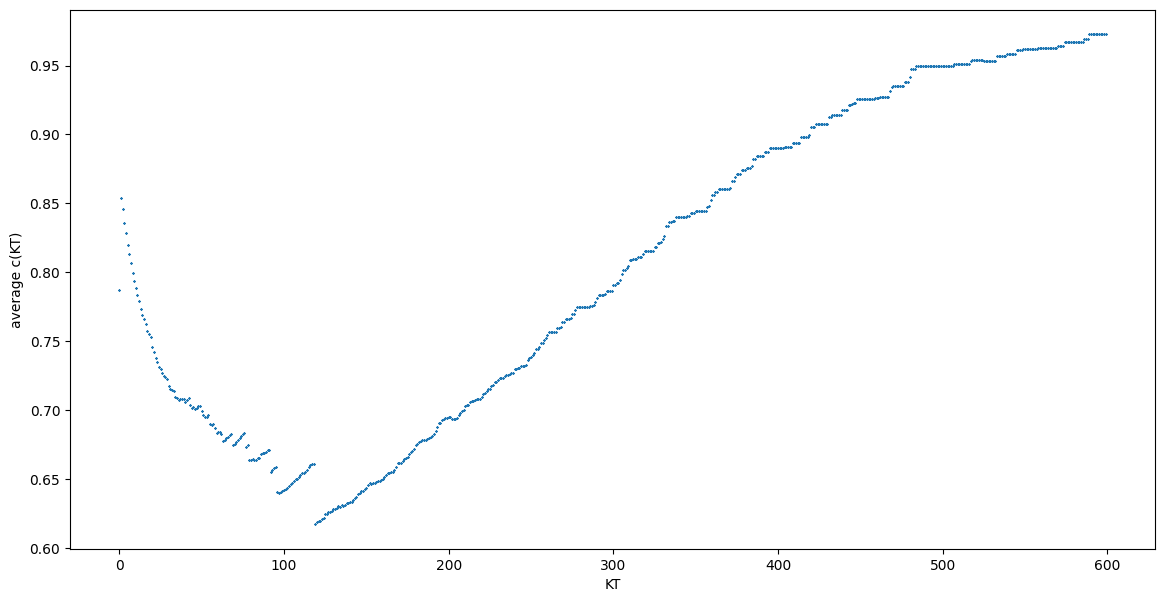

Cargado el grafo de la hora 437016, numero de nodos: 16490, numero de aristas: 254786


100%|██████████| 600/600 [25:17<00:00,  2.53s/it] 


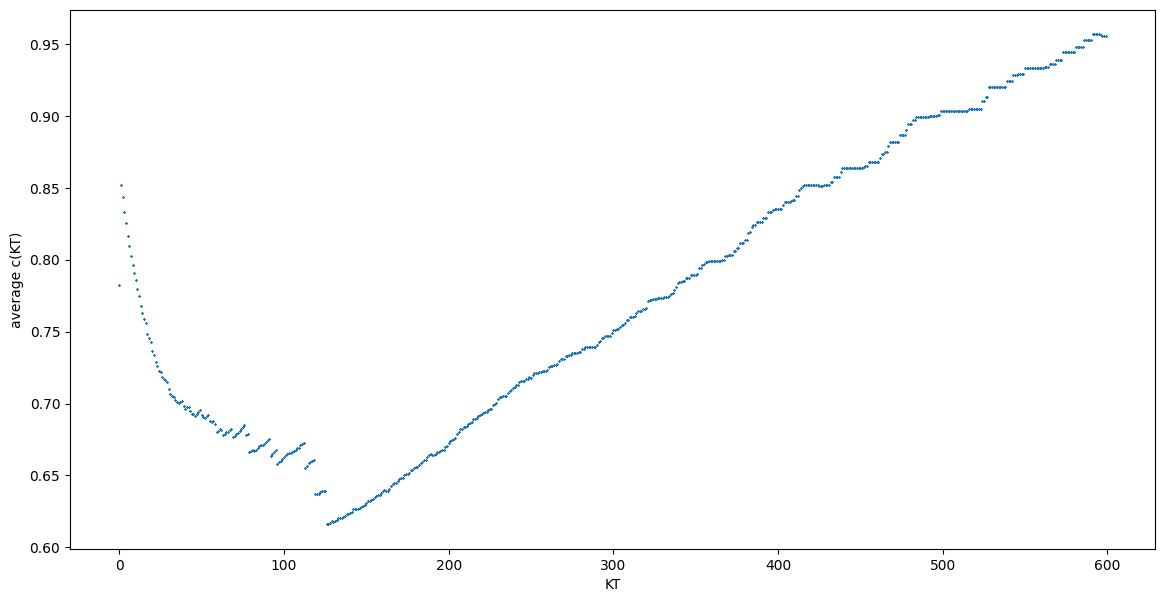

Cargado el grafo de la hora 437024, numero de nodos: 7279, numero de aristas: 92696


100%|██████████| 600/600 [03:50<00:00,  2.60it/s]


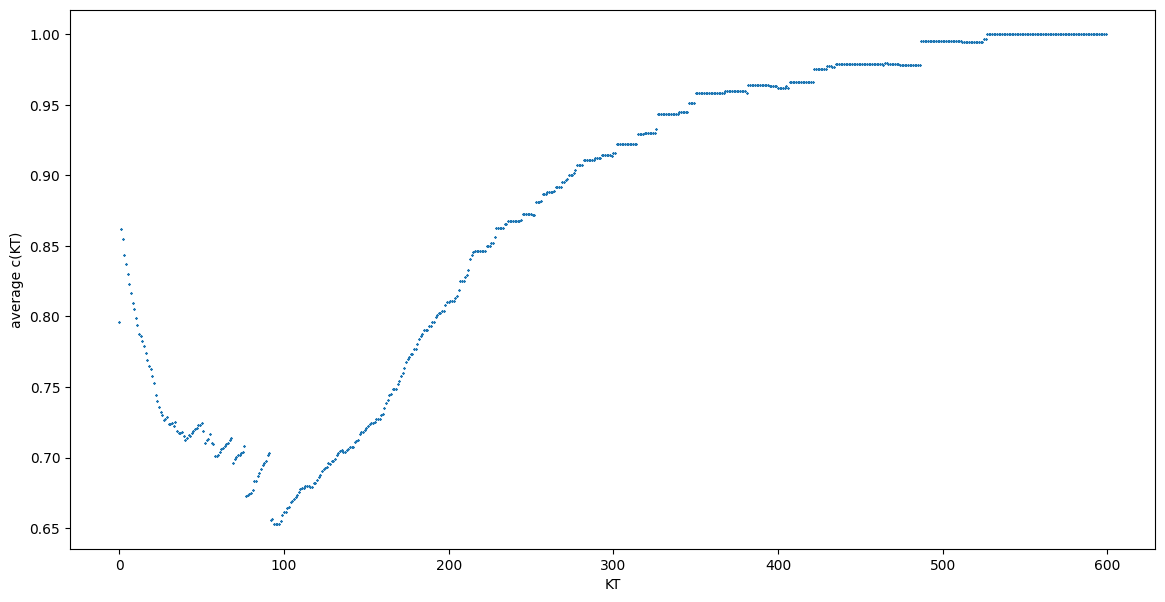

Cargado el grafo de la hora 437015, numero de nodos: 4525, numero de aristas: 57403


100%|██████████| 600/600 [01:36<00:00,  6.22it/s] 


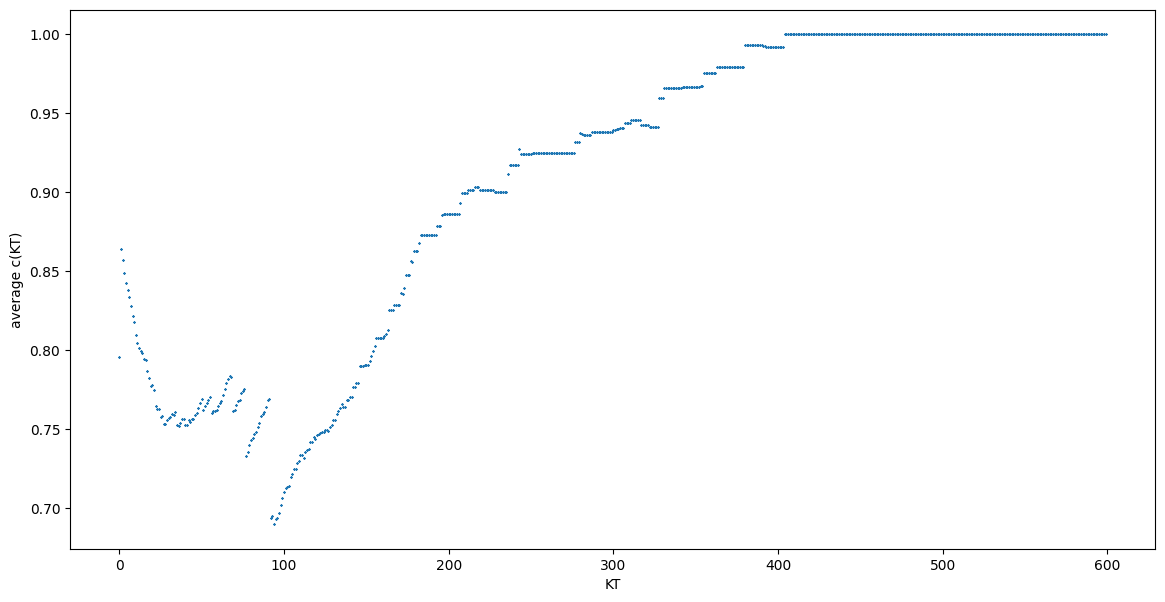

Cargado el grafo de la hora 437055, numero de nodos: 7680, numero de aristas: 99256


100%|██████████| 600/600 [04:13<00:00,  2.37it/s]


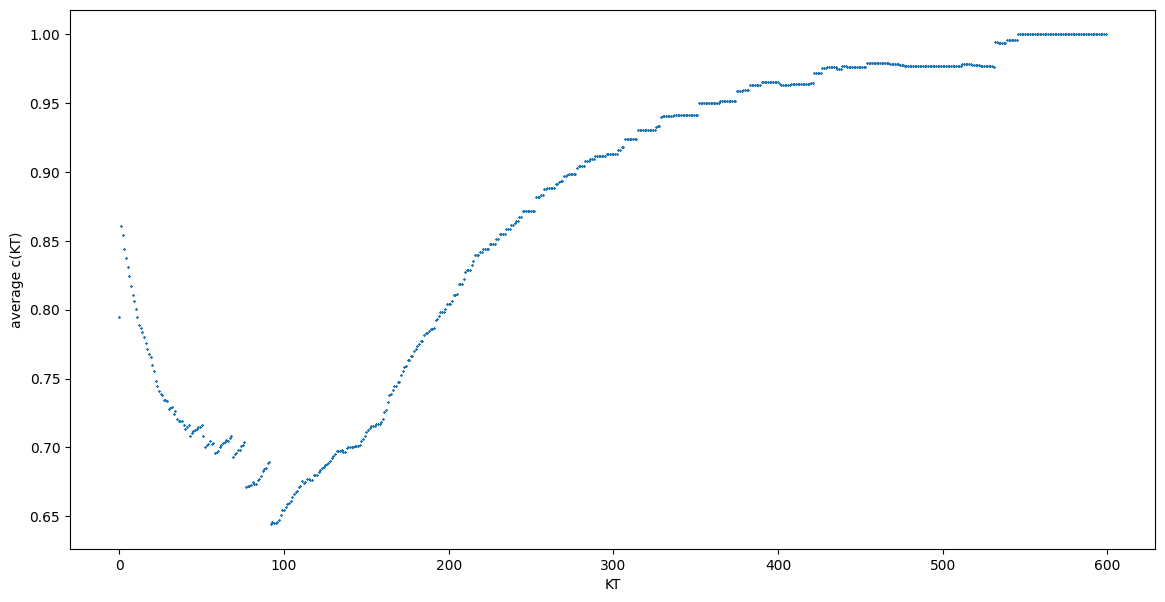

Cargado el grafo de la hora 437066, numero de nodos: 14683, numero de aristas: 220103


100%|██████████| 600/600 [19:02<00:00,  1.90s/it] 


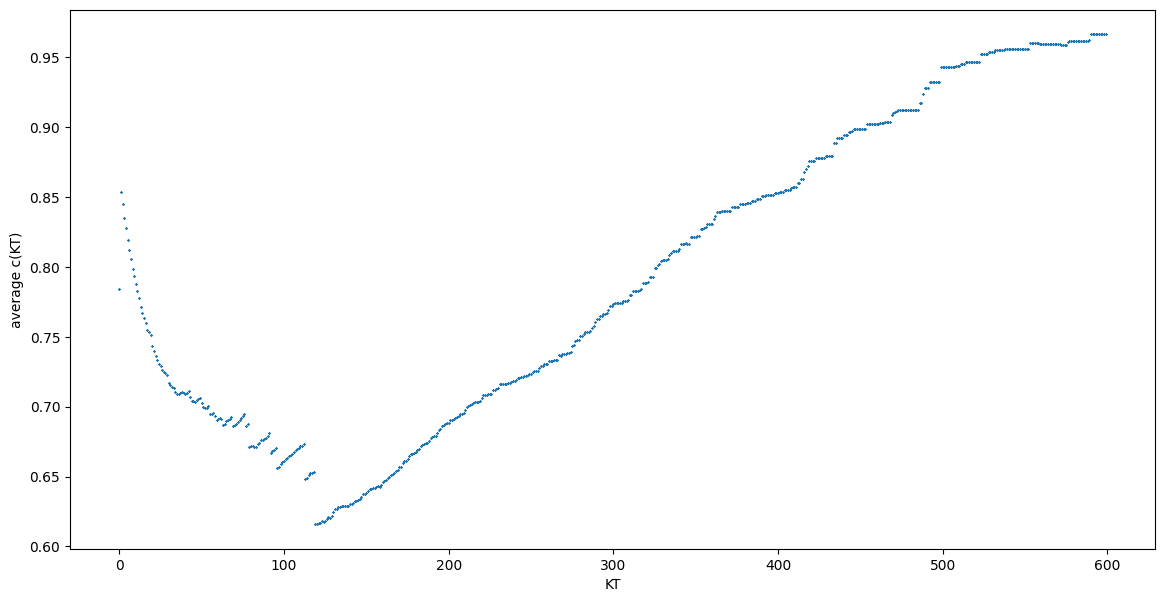

Cargado el grafo de la hora 437067, numero de nodos: 18465, numero de aristas: 287819


100%|██████████| 600/600 [32:10<00:00,  3.22s/it] 


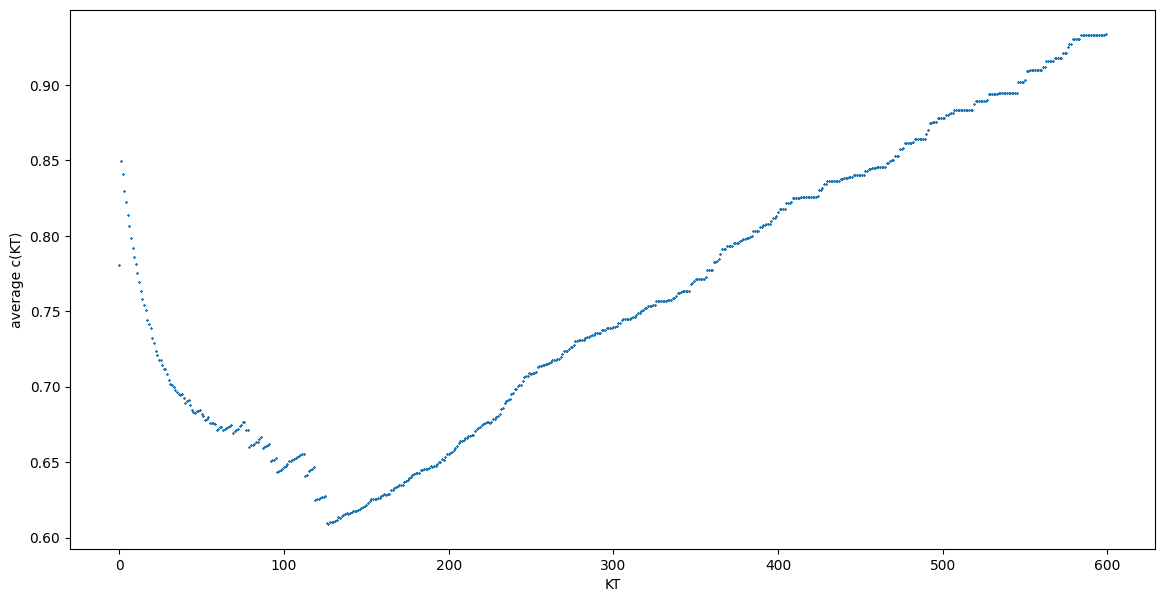

In [17]:
for root, dirs, files in os.walk(graphs_folder, topdown=False):
    for name in files:
        if name.endswith(".gexf"):
            if not os.path.exists("plots/" + name.split("_")[-1][:-5] + ".png"):
                calc_plot(name[:-5])
            
# Selecciono el grafo de la hora que nos interesa
#name_graph = "hashtags_sharing_users_437036"
# 437037 se corresponde con las 21:00 del 9n (momento explosion segun paper Yerali)
#calc_plot(name_graph)

In [ ]:
#H = tresh_normalization(G, 1)
#A graph is commonly classified as small-world if sigma>1.
sigma = nx.smallworld.sigma(G)
print("a")
# Values close to 0 mean that G has small-world characteristics.
omega = nx.smallworld.omega(G)

print("sigma: ", sigma, ", omega: ", omega)